---
title: Identifying type I and type II FRB 
subtitle: Extending the work of [@pleunis_FastRadioBurst_2021]
author: Murthadza Aznam
date: '2023-03-20'
bibliography: references.bib
---

:::{.callout-note}

 📌 Goal: This notebook tries to differentiate between broadband and shortband single peak fast radio burst, as described in [@pleunis_FastRadioBurst_2021].

:::

In [ ]:
import pandas as pd
import numpy as np
import scipy

In [ ]:
from sarjana.handlers import ParquetWaterfall
from sarjana.signal import find_peaks
from pathlib import Path
import matplotlib.pyplot as plt

single_file = Path('D://', 'home', 'datasets', 'sarjana', 'raw', 'wfall', 'FRB20190117A_waterfall.h5.parquet')

burst = ParquetWaterfall(single_file).remove_rfi()

In [ ]:
burst.wfall_dimension

In [ ]:
from copy import deepcopy

def dmdelay(dm,fx,fstart):
    return 4148.741601*(1.0/(fstart**2)
                          -(1.0/(fx**2)))*dm

def dedisperse(data,dm,f,fstart,tsamp,sep=False):
    temp = np.zeros(data.shape)
    delay = np.round(dmdelay(dm,f,fstart)/tsamp)
    for i in range(np.shape(temp)[1]):
        temp[:,i] = np.roll(data[:,i],int(delay[i]))
    return (temp if sep else np.sum(temp,axis=1))

In [ ]:
plt.imshow(burst.wfall, aspect="auto", interpolation="none",
                extent=burst.extent)

In [ ]:
from sarjana.signal import find_full_width_nth_maximum

widths, width_heights, lefts, rights = find_full_width_nth_maximum(
            burst.ts, peaks,
             n=10
        )

widths, width_heights, lefts, rights

In [ ]:
np.nanmean(np.transpose(burst.model_wfall)[int(lefts[0]):int(rights[0])], axis=0)

In [ ]:
import seaborn as sns
# TODO Select around the peaks OR select around the burst?
# TODO Systematic FWTM
# TODO OR should we just use high_freq and low_freq from CHIME/FRB?
# data = pd.DataFrame.from_dict({"peak": burst.plot_time[peaks[0]], "freq": burst.plot_freq, "wfall": np.transpose(burst.model_wfall)[peaks[0]]})
data = pd.DataFrame()
for peak, left, right in zip(peaks, lefts, rights):
    new = pd.DataFrame({"peak": burst.plot_time[peak], "freq": burst.plot_freq, "wfall": np.nanmean(np.transpose(burst.model_wfall)[int(left):int(right)+1], axis=0)})
    _,_, leftborder, rightborder = find_full_width_nth_maximum(
            new['wfall'], [new['wfall'].to_numpy().argmax()], n=10
        )
    data = pd.concat([data, new])
    data.loc[data['peak'] == burst.plot_time[peak], "left"] = leftborder[0]
    data.loc[data['peak'] == burst.plot_time[peak], "right"] = rightborder[0]
g = sns.FacetGrid(data, row='peak', aspect=15, height=2)
g.map(sns.lineplot, 'freq', 'wfall')

In [ ]:
from sarjana.plotting import plot_time_flux
from sarjana.signal import is_multipeak

is_multipeak(burst.ts, prominence='stdev')
plot_time_flux(burst.ts, burst.model_ts, burst.plot_time, burst.dt)

In [ ]:
from pathlib import Path
from sarjana.signal import is_multipeak, find_full_width_nth_maximum

catalog_file = Path('D://', 'home', 'datasets', 'sarjana', 'raw', 'cfod', 'chimefrb_profile_norfi.parquet')

catalog = pd.read_parquet(catalog_file)

# Resize time
catalog['plot_time'] = catalog['plot_time'] - (catalog['dt'] / 2)

catalog["multipeak"] = [is_multipeak(x.copy()) for x in catalog["ts"].values]
single_peaks = catalog[catalog["multipeak"] == False]
def time_width(flux, peaks, delta):
    widths, width_heights, lefts, rights = find_full_width_nth_maximum(
            flux, peaks, n=10
    )
    return widths[0]*delta
single_peaks['time_width'] = single_peaks.apply(lambda x: time_width(x['ts'].copy(), [x['ts'].argmax()], x['dt']), axis='columns')

In [ ]:
def gauss(time: np.ndarray, sigma: float, amplitude: float = 1.0, peak_time: float = 0.0):
    return amplitude * np.exp(-((time - peak_time) ** 2) / (2 * sigma**2))

def scattered_gaussian_signal(
    time: np.ndarray,
    sigma: float,
    tau: float,
    amplitude: float = 1.0,
    peak_time: float = 0.0,
) -> np.ndarray:
    _time = time - peak_time
    first_term: np.ndarray = -(_time / tau) + (sigma**2) / (2 * (tau**2))
    second_term: np.ndarray = (_time / (np.sqrt(2) * sigma)) - (
        sigma / (np.sqrt(2) * tau)
    )
    return amplitude * 0.5 * np.exp(first_term) * (1 + scipy.special.erf(second_term))

from typing import Callable
from sarjana.optimize import fit_time_series

def generate_single_peak_model(data: pd.DataFrame, func: Callable) -> pd.DataFrame:
    def try_fit(func, data) -> dict:
        try:
            return fit_time_series(
                func,
                data["plot_time"],
                data["ts"],
                params={
                    "amplitude": data["ts"].max(),
                    "peak_time": data["plot_time"][data["ts"].argmax()],
                },
            )
        except RuntimeError:
            return fit_time_series(
                func,
                data["plot_time"],
                data["model_ts"],
                params={
                    "amplitude": data["model_ts"].max(),
                    "peak_time": data["plot_time"][data["model_ts"].argmax()],
                },
            )

    data[func.__name__] = data.apply(
        lambda x: try_fit(func, x), axis="columns"
    )
    return data

In [ ]:
df1 = generate_single_peak_model(single_peaks, scattered_gaussian_signal)

data = df1[['eventname', 'dm', 'scattered_gaussian_signal', 'time_width']]
data['sigma']     = data['scattered_gaussian_signal'].apply(lambda x: x.get('sigma', 0)[0])
data['sigma_err'] = data['scattered_gaussian_signal'].apply(lambda x: x.get('sigma', 0)[1])
data['tau']       = data['scattered_gaussian_signal'].apply(lambda x: x.get('tau', 0)[0])
data['tau_err']   = data['scattered_gaussian_signal'].apply(lambda x: x.get('tau', 0)[1])
data['sigma_per_tau']       = data['sigma']/data['tau']

In [1]:
import os
from pathlib import Path
import pandas as pd
chime_catalog = Path(os.getenv('DATAPATH'), 'catalog.parquet')
cat = pd.read_parquet(chime_catalog)
cat['kmeans_label'].replace([0,1,2], ['narrowband', 'broadband','multipeak'], inplace=True)

In [ ]:
from sklearn.cluster import KMeans

# DBSCAN is not helpful because many data are focused on the limit

clusterer = KMeans(n_clusters=2).fit(cat.loc[cat["is_multipeak"] == False, ["bandwidth"]])
cat.loc[cat["is_multipeak"] == False, ["test_label"]] = clusterer.predict(cat.loc[cat["is_multipeak"] == False, ["bandwidth"]])
cat['test_label'] = cat['test_label'].fillna(2)

d:\home\kerja\sarjana\.venv\lib\site-packages\seaborn\axisgrid.py:1826: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)


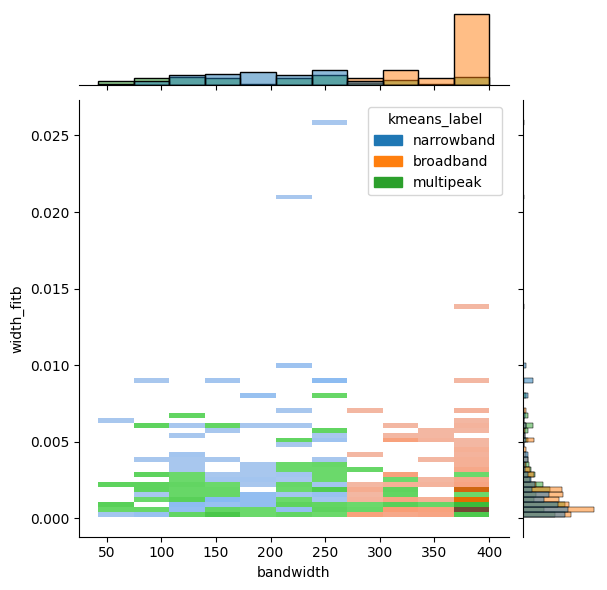

In [34]:
import numpy as np
import seaborn as sns

g=sns.jointplot(
    cat, x='bandwidth', y='width_fitb',kind='hist', hue='kmeans_label', palette=sns.color_palette(),
    # xlim=[10,410], ylim=[-0.0005, 0.03]
    # marginal_kws=dict(kind='hist')
    )
# g.plot_joint(sns.kdeplot, pallete=sns.color_palette())

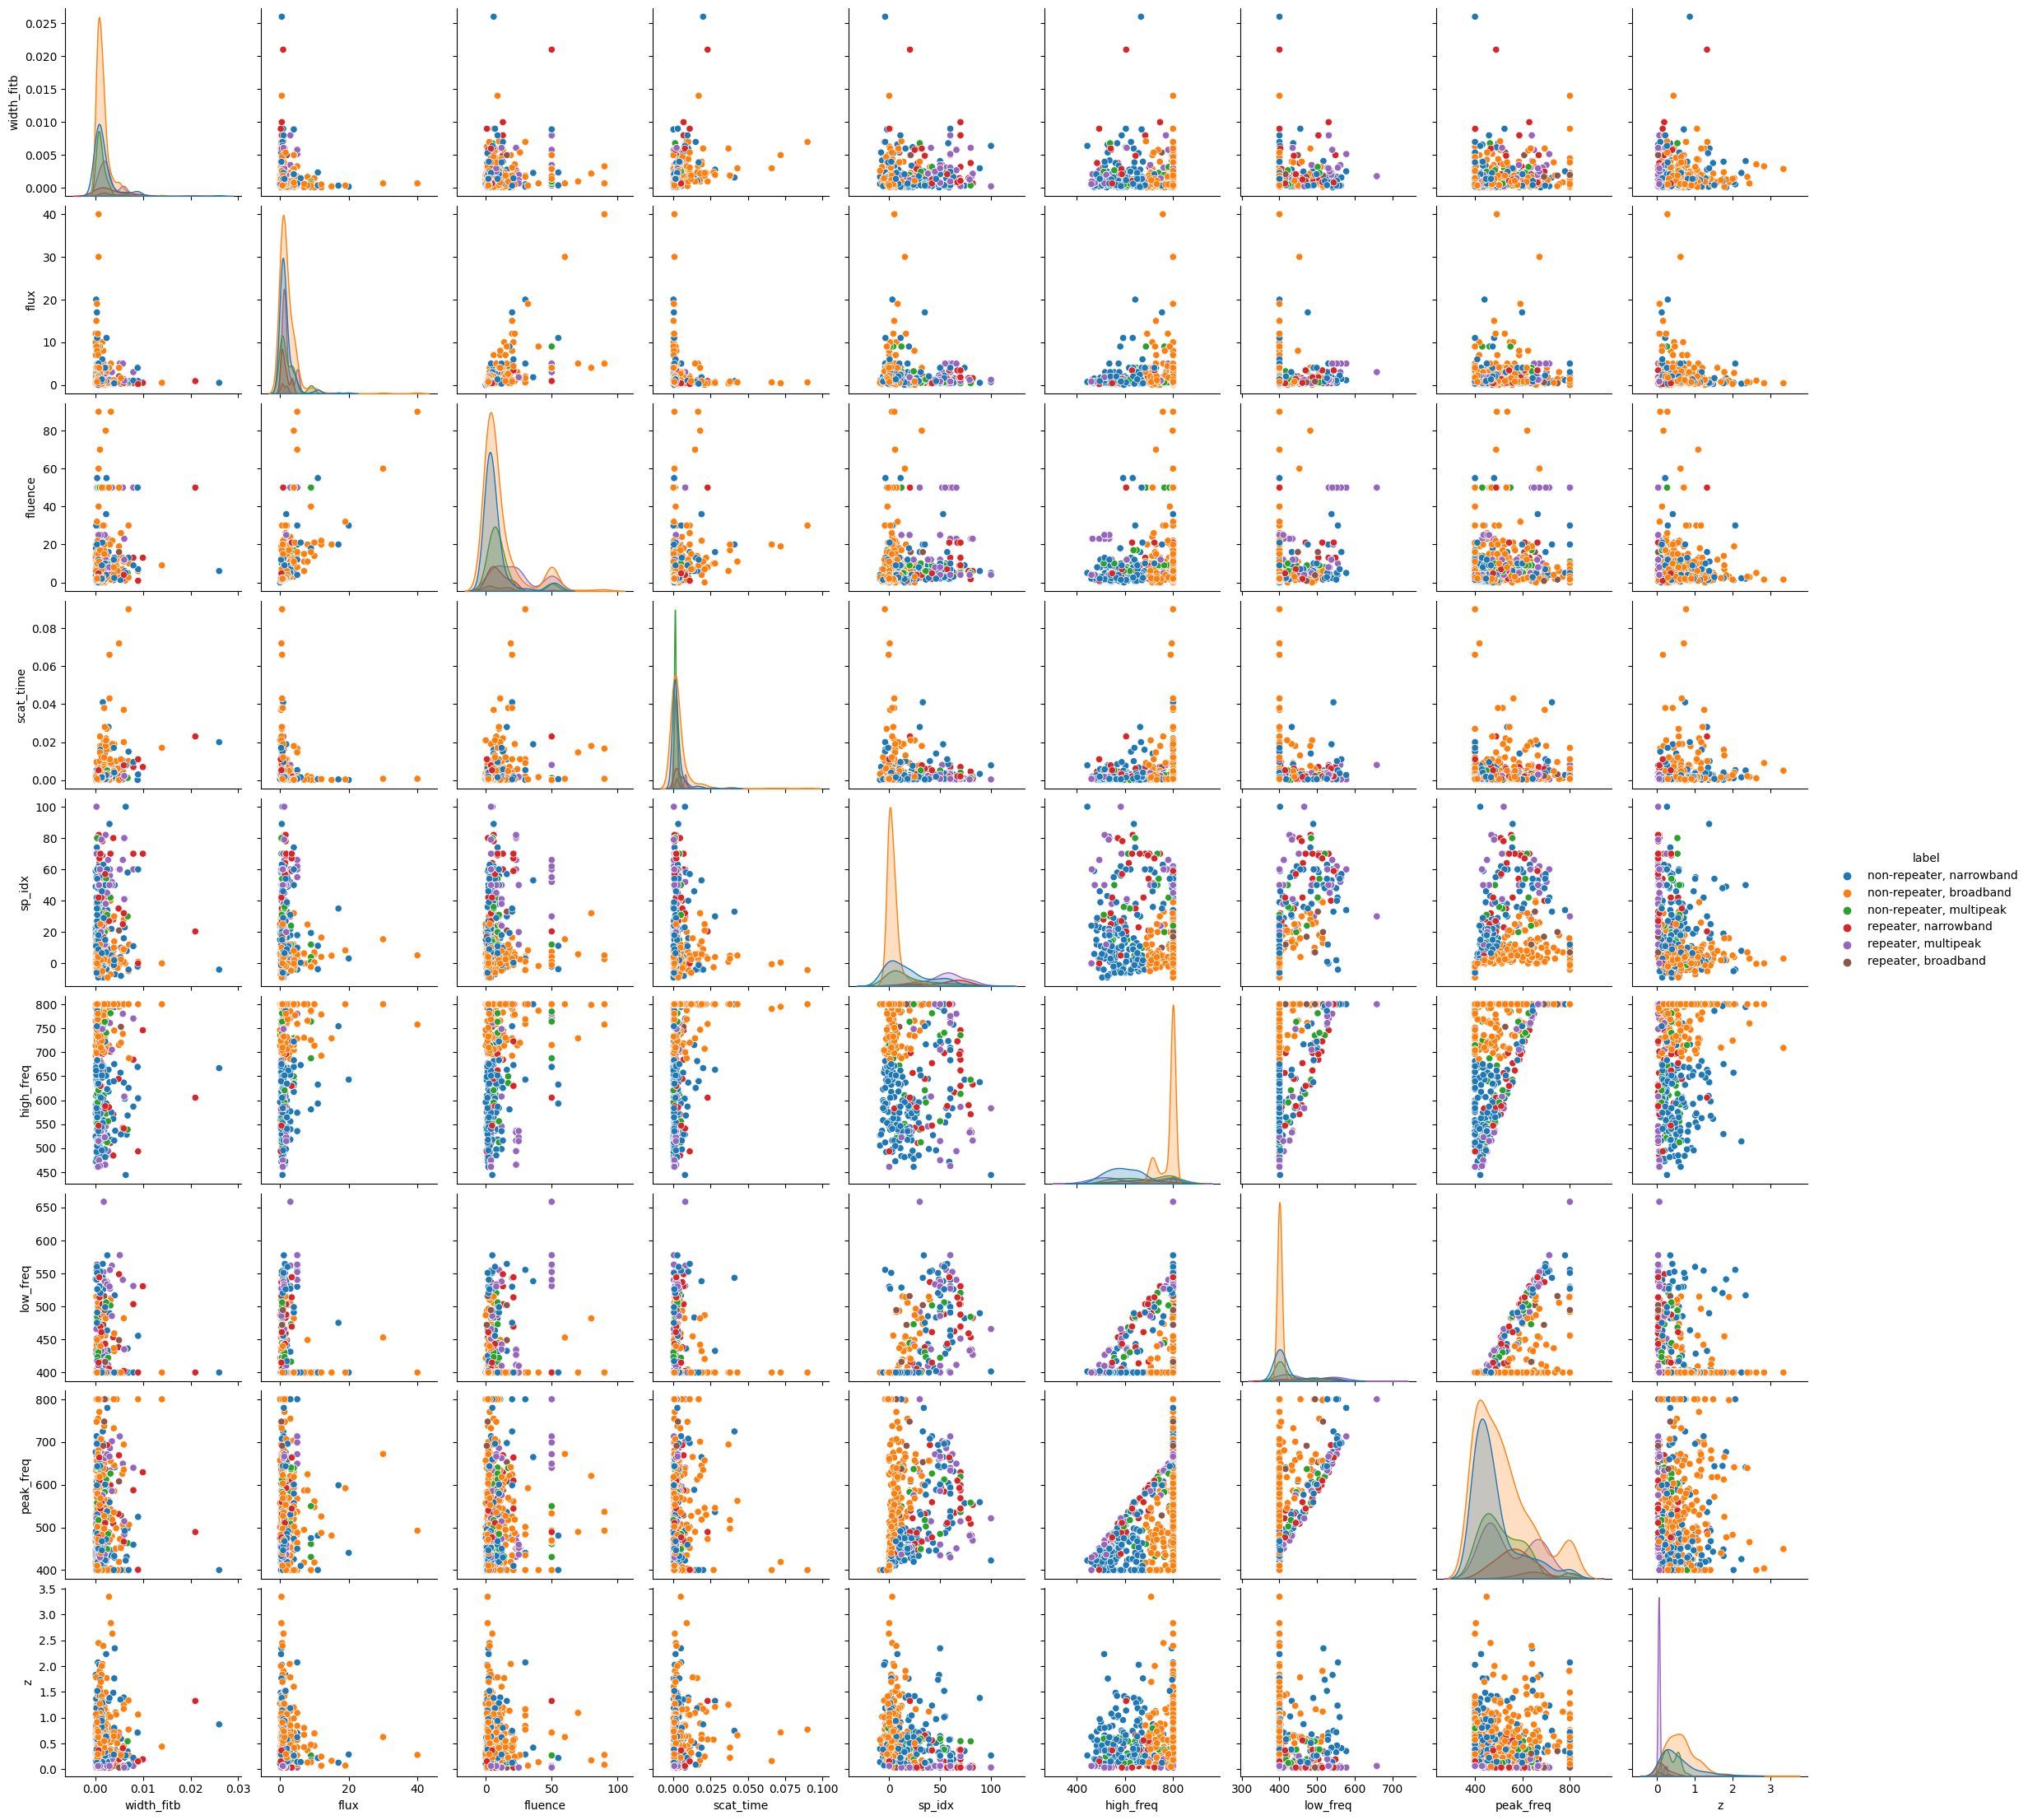

In [35]:
selected = ["width_fitb", "flux", "fluence", "scat_time", "sp_idx", "high_freq", "low_freq", "peak_freq", "z", "kmeans_label", "label"]

sns.pairplot(cat[selected], hue='label')

In [5]:
repeaters_samples = pd.read_csv(Path(os.getenv('DATAPATH'),'raw/external/FRBSTATS2022-11-23_repeaters.csv'), index_col=0)
cat["repeater"] = False
cat.loc[cat["eventname"].isin(repeaters_samples["samples"].str.replace(" ", "")),"repeater"] = True

In [26]:
cat['repeater']

0      False
1      False
2      False
3      False
4      False
       ...  
789    False
790    False
791    False
792    False
793    False
Name: repeater, Length: 794, dtype: bool

In [32]:
cat['label'] = cat.apply(lambda x: f'repeater, {x["kmeans_label"]}' if x['repeater'] else f'non-repeater, {x["kmeans_label"]}', axis='columns')
cat.to_parquet(Path(os.getenv('DATAPATH'), 'catalog-notebook.parquet'))

In [13]:
'width_fitb' in cat.columns

True

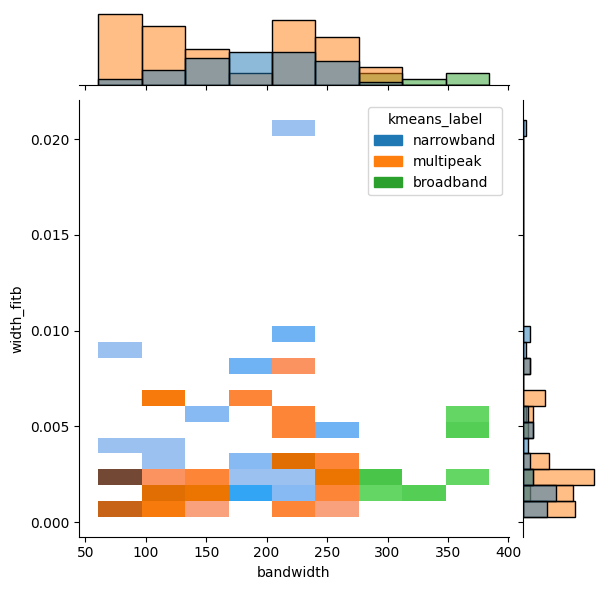

In [42]:
g = sns.jointplot(
    cat[cat['repeater']==True], 
    x='bandwidth', 
    y='width_fitb', 
    hue='kmeans_label', 
    kind='hist')

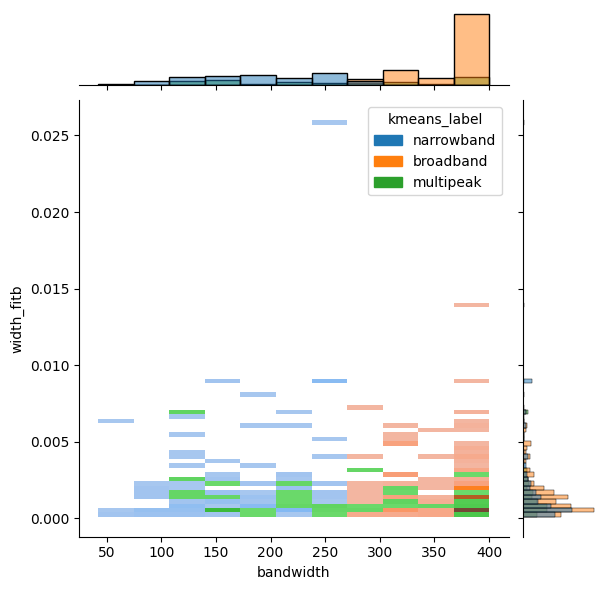

In [43]:
g = sns.jointplot(
    cat[cat['repeater']==False], 
    x='bandwidth', 
    y='width_fitb', 
    hue='kmeans_label', 
    kind='hist')

In [51]:
pd.crosstab(cat['repeater'], cat['kmeans_label'], normalize='all', margins=True)
# pd.crosstab(cat['repeater'], cat['kmeans_label'], normalize='columns', margins=True)
# pd.crosstab(cat['repeater'], cat['kmeans_label'], normalize='index', margins=True)

kmeans_label,broadband,multipeak,narrowband,All
repeater,,,,
False,0.420655,0.136020,0.240554,0.797229
True,0.012594,0.130982,0.059194,0.202771
All,0.433249,0.267003,0.299748,1.000000
